In [1]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool, cv
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error




In [2]:
#Importing datasets
train = pd.read_csv("//Users//anushreesv//Downloads//ABB_coding_test//train_v9rqX0R.csv")
test = pd.read_csv("//Users//anushreesv//Downloads//ABB_coding_test//test_AbJTz2l.csv")
print(f"Train -{train.shape}, Test -{test.shape}")

Train -(8523, 12), Test -(5681, 11)


In [3]:
## Concat the above datasets for preprocessing
sales_data=pd.concat([train,test],axis=0)
sales_data.shape

(14204, 12)

Data Preprocessing, Feature Engineering:
1. Outlier treatment
2. Missing value/zero value imputation
3. Binning the values of features
4. Creating new features/modifying the existing features

In [4]:
#Outliers are present in the target variable so replacing the with the 1st and 99th percentile values as needed
sales_data=sales_data.assign(Item_Outlet_Sales=lambda x: np.where(x['Item_Outlet_Sales'] > x['Item_Outlet_Sales'].quantile(0.99),x['Item_Outlet_Sales'].quantile(0.99),x['Item_Outlet_Sales']))
sales_data=sales_data.assign(Item_Outlet_Sales=lambda x: np.where(x['Item_Outlet_Sales'] < x['Item_Outlet_Sales'].quantile(0.01),x['Item_Outlet_Sales'].quantile(0.01),x['Item_Outlet_Sales']))


In [5]:
#Item_Visibility - zero values are present so replacing with the mean wrt Item_Identifier
item_visibility_group=sales_data.groupby('Item_Identifier')['Item_Visibility'].mean().reset_index()
item_visibility_group.columns=['Item_Identifier','Item_Visibility_Mean']

sales_data_iv_imp=pd.merge(sales_data,item_visibility_group,how='left',on='Item_Identifier')
sales_data_iv_imp['Item_Visibility']=np.where(sales_data_iv_imp['Item_Visibility']==0,sales_data_iv_imp['Item_Visibility_Mean'],sales_data_iv_imp['Item_Visibility'])
sales_data_iv_imp.drop(columns=['Item_Visibility_Mean'],inplace=True)
sales_data_iv_imp[sales_data_iv_imp['Item_Visibility']==0]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales


In [6]:
#Item_Weight - replacing the missing values with the mean weight wrt Item_Identifier
item_weight_mean=sales_data_iv_imp.groupby('Item_Identifier')['Item_Weight'].agg('mean').reset_index()
item_weight_mean.columns=['Item_Identifier','Item_Weight_Mean']
sales_data_iw_imp=pd.merge(sales_data_iv_imp,item_weight_mean,how='left',on='Item_Identifier')
sales_data_iw_imp['Item_Weight']=np.where(sales_data_iw_imp['Item_Weight'].isnull(),sales_data_iw_imp['Item_Weight_Mean'],sales_data_iw_imp['Item_Weight'])
sales_data_iw_imp.drop(columns=['Item_Weight_Mean'],inplace=True)
sales_data_iw_imp[sales_data_iw_imp['Item_Weight'].isnull()]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales


In [7]:
#Outlet_Size - there is direct relationship between Outlet_Size and Outlet_Type so replacing the missing values with the most frequent Outlet_Size for that Outlet_Type
sales_data_iw_imp['Outlet_Size']=sales_data_iw_imp['Outlet_Size'].fillna('Small')
sales_data_iw_imp.Outlet_Size.value_counts(dropna=False)

Outlet_Size
Small     7996
Medium    4655
High      1553
Name: count, dtype: int64

In [8]:
#Item_Type - categories are grouped into 3 broad categories
food=['Snack Foods','Frozen Foods', 'Canned', 'Breads', 'Breakfast', 'Meat', 'Seafood','Starchy Foods','Dairy','Fruits and Vegetables','Baking Goods']
Beaverages=['Soft Drinks', 'Hard Drinks']
Non_consumable=['Household', 'Health and Hygiene', 'Others']
sales_data_iw_imp['Item_Type2']=np.where(sales_data_iw_imp.Item_Type.isin(food),'Food',np.where(sales_data_iw_imp.Item_Type.isin(Beaverages),'Beverages',
                                        np.where(sales_data_iw_imp.Item_Type.isin(Non_consumable),'Non-Consumable-Items',sales_data_iw_imp.Item_Type)))
sales_data_iw_imp.drop(columns=['Item_Type'], inplace=True)
sales_data_iw_imp.rename(columns={'Item_Type2':'Item_Type'}, inplace=True)
sales_data_iw_imp['Item_Type'].value_counts(dropna=False)

Item_Type
Food                    10430
Non-Consumable-Items     2686
Beverages                1088
Name: count, dtype: int64

In [9]:
#Item_Fat_Content - 2 issues - 1. Categories are not standardized 2. Non food items are marked as low fat/regular
sales_data_iw_imp['Item_Fat_Content']=sales_data_iw_imp['Item_Fat_Content'].replace({'LF':'Low Fat','reg':'Regular','low fat':'Low Fat'})
sales_data_iw_imp.loc[sales_data_iw_imp['Item_Type']=='Non-Consumable-Items','Item_Fat_Content']='Not Applicable'
sales_data_iw_imp.Item_Fat_Content.value_counts()

Item_Fat_Content
Low Fat           6499
Regular           5019
Not Applicable    2686
Name: count, dtype: int64

In [10]:
#Outlet_Establishment_Year - creating a new variable Outlet_Years  the years of operation of the outlet(considering 2013 given in the problem statement) which is more intuitive
sales_data_iw_imp=sales_data_iw_imp.assign(Outlet_Years=lambda x: 2013 - x.Outlet_Establishment_Year)
sales_data_iw_imp.drop(columns=['Outlet_Establishment_Year'], inplace=True)
sales_data_iw_imp.Outlet_Years.value_counts()

Outlet_Years
28    2439
26    1553
14    1550
16    1550
9     1550
11    1548
4     1546
6     1543
15     925
Name: count, dtype: int64

Feature Encoding:

In [11]:

cat_features = sales_data_iw_imp.select_dtypes(include=['object']).columns.tolist() 
num_features = sales_data_iw_imp.select_dtypes(include=['int64', 'float64']).columns.tolist() 
print(f"Categorical features - {cat_features}\nNumerical features - {num_features}")

Categorical features - ['Item_Identifier', 'Item_Fat_Content', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'Item_Type']
Numerical features - ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Item_Outlet_Sales', 'Outlet_Years']


In [12]:
le=LabelEncoder()
for feature in cat_features:
    sales_data_iw_imp[feature]=le.fit_transform(sales_data_iw_imp[feature])

Checking the correlation between the features:

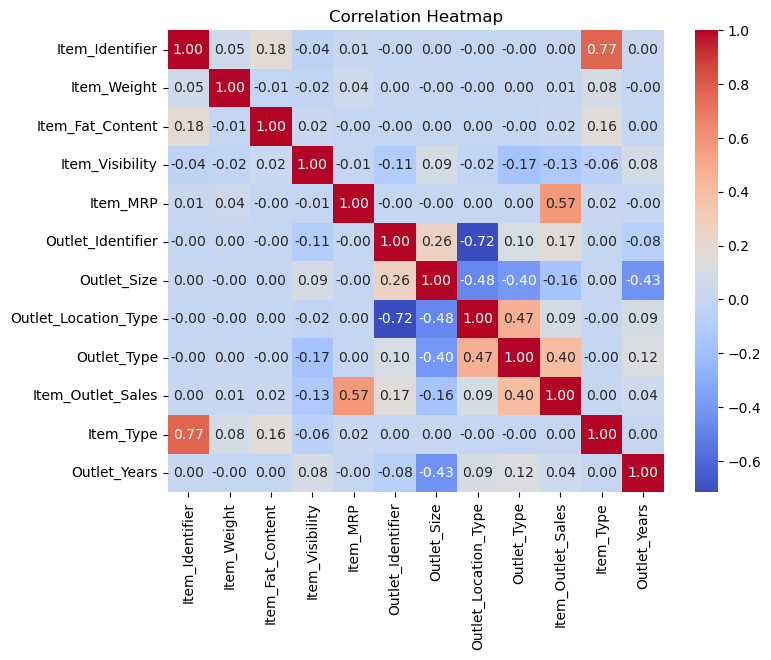

In [13]:
correlation_matrix=sales_data_iw_imp.corr()
plt.figure(figsize=(8, 6)) # Optional: Adjust figure size
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()
# We can see some expected correlations but taking all the features for modelling as CatBoost can handle multicollinearity well

Preparing the train & test datasets:

In [14]:
train_cleaned=sales_data_iw_imp[sales_data_iw_imp['Item_Outlet_Sales'].notnull()].reset_index(drop=True)
test_cleaned=sales_data_iw_imp[sales_data_iw_imp['Item_Outlet_Sales'].isnull()].reset_index(drop=True)
test_cleaned.drop(columns=['Item_Outlet_Sales'], inplace=True)
print(f"Train_cleaned -{train_cleaned.shape}, Test_cleaned -{test_cleaned.shape}")

Train_cleaned -(8523, 12), Test_cleaned -(5681, 11)


In [15]:
X=train_cleaned.drop(columns=['Item_Outlet_Sales'])
y=train_cleaned['Item_Outlet_Sales']

In [16]:
cat_cols= X.select_dtypes('object').columns
print(cat_cols)

Index([], dtype='object')


In [17]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2)

Model fitting and Evaluation:

In [18]:
def train_and_evaluate_model(model, model_name):
    """Train the model and evaluate its performance"""
    model.fit(X_train, y_train)

    # Training metrics
    y_train_pred = model.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_r2 = r2_score(y_train, y_train_pred)

    # Validation metrics
    y_val_pred = model.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    val_r2 = r2_score(y_val, y_val_pred)

    # Append metrics to the list
    metrics_list.append({
        'model': model_name,
        'R-Square_train': train_r2,
        'R-Square_test': val_r2,
        'RMSE_train': train_rmse,
        'RMSE_test': val_rmse
    })

    print(f"{model_name} - Train RMSE: {train_rmse}, Train R2: {train_r2}")
    print(f"{model_name} - Test RMSE: {val_rmse}, Test R2: {val_r2}")

In [19]:

# Define models
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100,
                                            max_depth=6,
                                            min_samples_split=5,
                                            random_state=42,
                                            min_samples_leaf=100,
                                            n_jobs=4),
    'Gradient Boosting': GradientBoostingRegressor(max_depth=5,
                                                    learning_rate=0.1,
                                                    n_estimators=200,
                                                    random_state=42,
                                                    min_samples_split=3,
                                                    subsample=0.8, 
                                                    min_samples_leaf=100,
                                                    max_features=5,
                                                    validation_fraction=0.2,
                                                    criterion='squared_error'),
    'XGBoost': XGBRegressor(booster='gbtree',
                                max_depth=5,
                                learning_rate=0.1,
                                n_estimators=30,
                                random_state=42,
                                min_samples_split=3,
                                reg_alpha=1,
                                # reg_lambda=1,
                                subsample=0.8,
                                objective='reg:squarederror'),
    'CatBoost': CatBoostRegressor(iterations=1000,
                            learning_rate=0.01,
                            depth=8,
                            cat_features=list(cat_cols),
                            random_seed=42,
                            loss_function='RMSE',
                            l2_leaf_reg=10,
                            verbose=False) 
}

# Train and evaluate each model
metrics_list = []
for model_name, model in models.items():
    train_and_evaluate_model(model, model_name)

# Convert metrics to DataFrame
metrics_df = pd.DataFrame(metrics_list)
print(metrics_df)

Random Forest - Train RMSE: 1021.2803925707126, Train R2: 0.6164833327482762
Random Forest - Test RMSE: 1101.0571817229509, Test R2: 0.5882227839696698
Gradient Boosting - Train RMSE: 938.2406012951606, Train R2: 0.6763149062321421
Gradient Boosting - Test RMSE: 1098.9376298316345, Test R2: 0.5898066129134141
XGBoost - Train RMSE: 996.1287341819432, Train R2: 0.6351408933823479
XGBoost - Test RMSE: 1099.7339903183163, Test R2: 0.5892118927827701


/Users/anushreesv/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:55:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


CatBoost - Train RMSE: 953.9147588045163, Train R2: 0.6654096655842004
CatBoost - Test RMSE: 1092.2722492131404, Test R2: 0.5947674103817451
               model  R-Square_train  R-Square_test   RMSE_train    RMSE_test
0      Random Forest        0.616483       0.588223  1021.280393  1101.057182
1  Gradient Boosting        0.676315       0.589807   938.240601  1098.937630
2            XGBoost        0.635141       0.589212   996.128734  1099.733990
3           CatBoost        0.665410       0.594767   953.914759  1092.272249


CatBoost Regression: CatBoost is performing well on test data.
Finding the optimum parameters using Gridsearch. 

In [20]:
model_cat=CatBoostRegressor(cat_features=list(cat_cols),verbose=False)

In [21]:
train_dataset = Pool(X_train, y_train) 
test_dataset = Pool(X_val, y_val)

In [22]:
## grid serach to get optimum paramter values
grid = {'iterations': [400, 500, 600],
        'learning_rate': [0.03, 0.01,1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [10, 15, 20]
        }
grid_search=model_cat.grid_search(grid, train_dataset)


bestTest = 1027.404698
bestIteration = 358

0:	loss: 1027.4046977	best: 1027.4046977 (0)	total: 894ms	remaining: 1m 35s

bestTest = 1044.497144
bestIteration = 399

1:	loss: 1044.4971442	best: 1027.4046977 (0)	total: 1.73s	remaining: 1m 31s

bestTest = 1039.094313
bestIteration = 17

2:	loss: 1039.0943129	best: 1027.4046977 (0)	total: 2.57s	remaining: 1m 29s

bestTest = 1027.376342
bestIteration = 392

3:	loss: 1027.3763416	best: 1027.3763416 (3)	total: 3.41s	remaining: 1m 28s

bestTest = 1045.114303
bestIteration = 399

4:	loss: 1045.1143029	best: 1027.3763416 (3)	total: 4.28s	remaining: 1m 28s

bestTest = 1044.403599
bestIteration = 25

5:	loss: 1044.4035988	best: 1027.3763416 (3)	total: 5.16s	remaining: 1m 27s

bestTest = 1027.134363
bestIteration = 392

6:	loss: 1027.1343634	best: 1027.1343634 (6)	total: 6.04s	remaining: 1m 27s

bestTest = 1045.944554
bestIteration = 399

7:	loss: 1045.9445544	best: 1027.1343634 (6)	total: 6.92s	remaining: 1m 26s

bestTest = 1044.204844
bestIterat

In [23]:
model_cat.fit(X_train,y_train)
# Predict on the training data
y_train_pred = model_cat.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, y_train_pred)
print(f"Train RMSE: {train_rmse}, Train R2: {train_r2}")

# Predict on test data
y_pred=model_cat.predict(X_val)
mse=mean_squared_error(y_val,y_pred)
rmse=np.sqrt(mse)
r2=r2_score(y_val,y_pred)
print(f"Test RMSE: {rmse}, Test R2: {r2}")

Train RMSE: 1005.630518244331, Train R2: 0.6281471248348603
Test RMSE: 1088.7519154277131, Test R2: 0.5973752860729036


In [24]:
metrics_df

,model,R-Square_train,R-Square_test,RMSE_train,RMSE_test
0,Random Forest,0.616483,0.588223,1021.280393,1101.057182
1,Gradient Boosting,0.676315,0.589807,938.240601,1098.937630
2,XGBoost,0.635141,0.589212,996.128734,1099.733990
3,CatBoost,0.665410,0.594767,953.914759,1092.272249


In [29]:
#adding catboost metrics and creating the final leaderboard
#removing older catboost prediction
metrics_df = metrics_df.iloc[:-1]
catboost_metrics = {
    'model': 'CatBoost',
    'R-Square_train': train_r2.round(2),
    'R-Square_test': r2.round(2),
    'RMSE_train': train_rmse.round(2),
    'RMSE_test': rmse.round(2)
}

leaderboard = pd.concat([metrics_df, pd.DataFrame([catboost_metrics])], ignore_index=True)
print(leaderboard)

               model  R-Square_train  R-Square_test   RMSE_train    RMSE_test
0      Random Forest        0.616483       0.588223  1021.280393  1101.057182
1  Gradient Boosting        0.676315       0.589807   938.240601  1098.937630
2            XGBoost        0.635141       0.589212   996.128734  1099.733990
3           CatBoost        0.630000       0.600000  1005.630000  1088.750000


In [26]:
#To check the feature importance
pd.DataFrame(X.columns,model.feature_importances_)

,0
2.448917,Item_Identifier
3.027629,Item_Weight
1.630403,Item_Fat_Content
2.996892,Item_Visibility
36.289935,Item_MRP
2.101126,Outlet_Identifier
2.003827,Outlet_Size
1.791216,Outlet_Location_Type
39.232492,Outlet_Type
0.785388,Item_Type


In [27]:
# Run predtions on the test dataset
y_test_pred=model.predict(test_cleaned)

In [28]:
#save the predictions in the required format
predictions=pd.concat([test[['Item_Identifier','Outlet_Identifier']],pd.DataFrame(y_test_pred,columns=['Item_Outlet_Sales'])],axis=1)
predictions.to_csv('//Users//anushreesv//Downloads//ABB_coding_test//catboost_predictions_submission.csv', index=False)